**Distributional semantics** is the study using statistical distributions of elements of language to characterize similarities between documents (e.g. email), speech acts (e.g. spoken or written sentence), or elements there of (e.g. phrases, words). The idea for this field comes from John R. Firth, a linguist in the first half of the 20th Century. He noted how semantics was dependent on context, and coined the oft repeated quote  You shall know a word by the company it keeps.

In [1]:
! pip install sklearn scipy wordcloud nltk

In [2]:
from collections import defaultdict, Counter, OrderedDict

In [3]:
import numpy as np
import pandas as pd
import scipy.sparse as sparse

from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import nltk
from nltk.corpus import stopwords
from nltk.corpus import brown

In [5]:
nltk.download('brown')
nltk.download('stopwords')

[nltk_data] Downloading package brown to /home/jovyan/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
en_stopwords = set(stopwords.words('english'))

In [7]:
def detokenize(sentence):
    text = ''
    for token in sentence:
        if text and any(c.isalnum() for c in token):
            text += " "
        text += token
    return text

now remove punctuations from stop words so our algo could only use useful words

In [8]:
def process(sentence):
    terms = []
    for term in sentence:
        term = term.lower()
        if term not in en_stopwords and term.isalnum():
            terms.append(term)
    return terms

gather docs

In [9]:
docs = OrderedDict()

for fid in brown.fileids():
    docs[fid] = brown.sents(fid)

##### now construct indexes, this can be used in information retrieval as well 

In [10]:
ix2doc = list(docs)
doc2ix = {fid: i for i, fid in enumerate(ix2doc)}
vocabulary = set()

term_counts = defaultdict(Counter)
document_counts = Counter()

for fid, doc in docs.items():
    unique_terms = set()
    for sentence in doc:
        sentence = process(sentence)
        term_counts[fid].update(sentence)
        unique_terms.update(sentence)
    document_counts.update(unique_terms)
    vocabulary.update(unique_terms)
    
ix2term = sorted(list(vocabulary))
term2ix = OrderedDict()
for i, term in enumerate(ix2term):
    term2ix[term] = i

##### now we have our indexes, time to construct TF and IDF


In [11]:
term_count_mat = sparse.dok_matrix((len(doc2ix), len(term2ix)))

for fid, i in doc2ix.items():
    for term, count in term_counts[fid].items():
        j = term2ix[term]
        term_count_mat[i, j] = count
term_count_mat = term_count_mat.todense()

doc_count_vec = np.array(
[document_counts[term] for term in term2ix.keys()])

In [12]:
tf = np.log(term_count_mat + 1)
idf = len(doc2ix) / (1 + doc_count_vec)
tfidf = np.multiply(tf, idf)

In [13]:
tfidf.shape

(500, 40881)

##### This is a rather large matrix for such a small dataset. Apart from space efficiency concerns, having this many dimensions can worsen performence for some algorithms. This is when distributional semantics can help.  Now, we can build our model.

In [14]:
from sklearn.cluster import KMeans

In [15]:
K = 6
clusters = ['cluster#{}'.format(k) for k in range(K)]
model = KMeans(n_clusters=K, random_state=314)

In [16]:
clustered = model.fit_transform(tfidf)

In [17]:
clustered.shape

(500, 6)

##### We can see that we have now clustered our documents using our 6 centroids. Each of these centroids is a vector over our vocabulary. We can look at which words are most influential on our centroids. We will use wordclouds for this.

In [18]:
model.cluster_centers_.shape

(6, 40881)

In [19]:
cluster_term = pd.DataFrame(
model.cluster_centers_.T, index=ix2term, columns=clusters)
cluster_term = np.round(cluster_term, decimals=4)

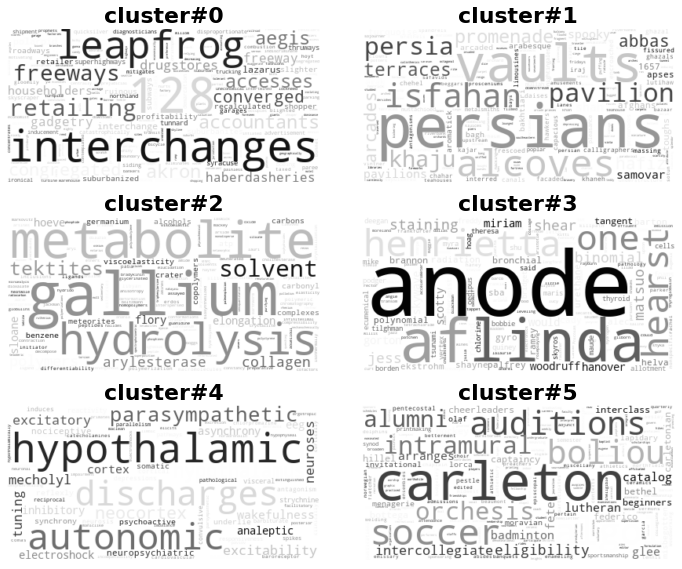

In [20]:
font = {'weight': 'bold', 'size': 22}
fig, axs = plt.subplots(K//2, 2, figsize=(10, 8))

k=0
for i in range(len(axs)):
    for j in range(len(axs[i])):
        wc = WordCloud(colormap='Greys', background_color='white')
        im = wc.generate_from_frequencies(cluster_term[clusters[k]])
        axs[i][j].imshow(im, interpolation='bilinear')
        axs[i][j].axis('off')
        axs[i][j].set_title(clusters[k], **font)
        k += 1
plt.tight_layout()
plt.show()

## Latent Semantic Indexing 

Latent Semantic Indexing is technique for decomposing the document-term matrix using Singular Value Decomposition or SVD. In SVD we decompose a matrix into three matrices.  <br>M → U Σ V^(T)  <br>Σ is a diagonal matrix of the singular values in descending order. We can take the top K, and this serves as an approximation of the original matrix. The first K columns of U are the representation of the documents in the K dimensional space. The first K columns of V are the representation of the terms in the K dimensional space. This allows us to compare the similarity of documents and terms. It is common to choose a larger number for the components, since the more dimensions Σ has the more dimensions we can use to approximate the original matrix. So we will set K to be higher number here.

In [27]:
from sklearn.decomposition import TruncatedSVD

In [28]:
K = 100
clusters = ['cluster#{}'.format(k) for k in range(K)]
model = TruncatedSVD(n_components=K)

In [29]:
clustered = model.fit_transform(tfidf)

In [30]:
model.singular_values_

array([3529.39876451, 3244.50812493, 3096.10206961, 3004.85841476,
       2814.67920036, 2778.91702384, 2754.40661008, 2714.44681323,
       2652.37578335, 2632.09500694, 2578.23253814, 2496.86846012,
       2479.34640582, 2468.9049692 , 2465.10703946, 2448.59353403,
       2425.03981473, 2414.64329925, 2407.77412161, 2392.91686178,
       2380.14663798, 2369.66070339, 2346.03303671, 2339.7602467 ,
       2325.55262622, 2320.63982329, 2310.93360344, 2307.38093803,
       2301.19966105, 2298.89310036, 2294.93371543, 2286.9684418 ,
       2279.27369572, 2274.68747784, 2267.76768149, 2263.02527306,
       2255.7505215 , 2253.95930609, 2252.06839522, 2240.65601777,
       2225.89509741, 2220.38957626, 2214.29653957, 2203.94785614,
       2201.55591203, 2188.75965571, 2183.66664446, 2180.98322512,
       2176.60067437, 2170.00305001, 2162.73739159, 2161.71939956,
       2154.42954022, 2148.08376187, 2142.45610956, 2136.75874183,
       2130.48894373, 2124.5518026 , 2119.85548793, 2116.40255

In [31]:
cluster_term = pd.DataFrame(model.components_.T,
                            index=ix2term, columns=clusters)
cluster_term = np.round(cluster_term, decimals=4)

In [32]:
cluster_term.loc[['polynomial', 'cat', 'frankfurter']]

,cluster#0,cluster#1,cluster#2,cluster#3,cluster#4,cluster#5,cluster#6,cluster#7,cluster#8,cluster#9,...,cluster#90,cluster#91,cluster#92,cluster#93,cluster#94,cluster#95,cluster#96,cluster#97,cluster#98,cluster#99
polynomial,0.0003,0.0011,0.0027,0.0023,0.0048,-0.0041,-0.0000,-0.0009,-0.0051,-0.0042,...,0.0002,-0.0145,0.0142,-0.0056,-0.0074,0.0025,-0.0092,0.0018,0.0027,-0.0015
cat,0.0002,0.0018,0.0005,0.0006,0.0053,-0.0047,0.0003,0.0145,-0.0003,0.0007,...,-0.0023,0.0033,-0.0047,-0.0023,0.0024,-0.0021,-0.0037,0.0014,-0.0032,-0.0036
frankfurter,0.0004,0.0018,0.0031,0.0021,0.0362,-0.0348,0.0071,-0.0214,0.0062,0.1060,...,0.0019,0.0032,0.0019,-0.0065,0.0011,0.0001,0.0080,0.0013,-0.0003,0.0049


##### Since we did not stem our words, let’s see if we can find “polynomials, from the vector for “polynomial”. We will use cosine similarity for this. Cosine similarity is a technique for looking at the similarity between two vectors. The idea is that we want to look at the angle between two vectors. If they are parallel, the similarity should be 1, if they are orthogonal, the similarity should be 0, and if they are going in opposite directions the similarity should be -1. So we want to look at the cosine of the angle between of them. The dot product of two vectors is equal to the product the magnitudes of the two vectors times the cosine of the angle between them. So, we can take the dot product divided by the product of the magnitudes.

In [33]:
from scipy.spatial.distance import cosine

def cossim(u, v):
    return 1 - cosine(u, v)

lets find the similarity between the term polynomial with other terms

In [40]:
polynomial_vec = cluster_term.iloc[term2ix['polynomial']]

similarities = cluster_term.apply(
lambda r: cossim(polynomial_vec, r), axis=1)

In [41]:
similarities.sort_values(ascending=False)[:20]

polynomial        1.000000
nilpotent         0.999999
commute           0.999999
polynomials       0.999999
diagonalizable    0.999999
subspace          0.999999
divisible         0.999998
monic             0.999998
satisfies         0.999998
algebraically     0.999998
differentiable    0.999998
spanned           0.999997
primes            0.999997
decomposes        0.999997
algebra           0.999997
scalar            0.999997
commutes          0.999997
subspaces         0.999992
irreducible       0.999992
integers          0.999992
dtype: float64

least similar terms

In [42]:
similarities.sort_values(ascending=True)[:20]

emma            -0.252640
pens            -0.237094
weakening       -0.235650
fortunately     -0.229604
dismay          -0.219849
swerving        -0.209596
dreamy          -0.209414
imposition      -0.208350
banisters       -0.206974
hobbled         -0.205099
sneezing        -0.205075
mammas          -0.205075
carrozza        -0.205075
fuchsia         -0.205075
unamused        -0.205075
unnaturally     -0.205075
enamelled       -0.205075
appian          -0.205075
motorscooters   -0.205075
heroically      -0.205075
dtype: float64

let’s build the wordclouds for our LSI model now. We will only look at the first and last three, since we have so many more clusters than our K-Means model.

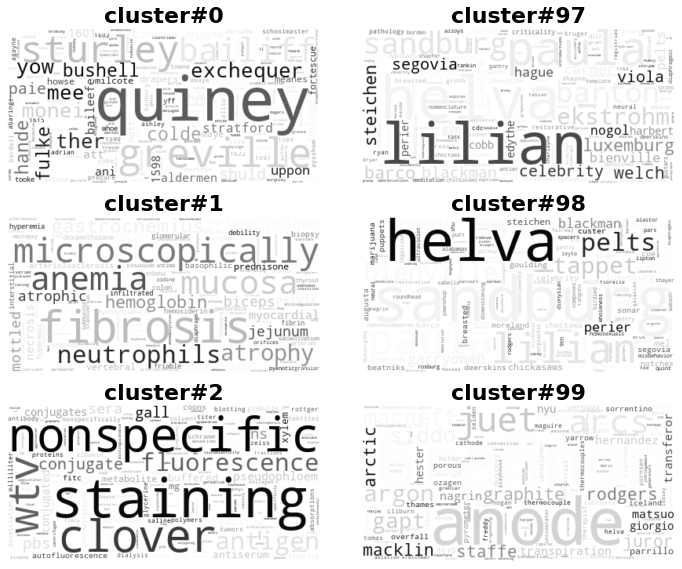

In [46]:
chosen_ix = [0, 97, 1, 98, 2, 99]

fig, axs = plt.subplots(3, 2, figsize=(10, 8))

k=0
for i in range(len(axs)):
    for j in range(len(axs[i])):
        wc = WordCloud(colormap='Greys', background_color='white')
        im = wc.generate_from_frequencies(cluster_term[clusters[chosen_ix[k]]])
        axs[i][j].imshow(im, interpolation='bilinear')
        axs[i][j].axis('off')
        axs[i][j].set_title(clusters[chosen_ix[k]], **font)
        k += 1

plt.tight_layout()
plt.show()